**Import GloVe Embeddings**

In [ ]:
import csv
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
glove = torchtext.vocab.GloVe(name="6B", # Specified corpus used to train embedding
                              dim=50)    # Specified dimension of embedding

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Example GloVe embedding output**

In [ ]:
print(glove["car"])
print(glove["queen"])

tensor([ 0.4769, -0.0846,  1.4641,  0.0470,  0.1469,  0.5082, -1.2228, -0.2261,
         0.1931, -0.2976,  0.2060, -0.7128, -1.6288,  0.1710,  0.7480, -0.0619,
        -0.6577,  1.3786, -0.6804, -1.7551,  0.5832,  0.2516, -1.2114,  0.8134,
         0.0948, -1.6819, -0.6450,  0.6322,  1.1211,  0.1611,  2.5379,  0.2485,
        -0.2682,  0.3282,  1.2916,  0.2355,  0.6147, -0.1344, -0.1324,  0.2740,
        -0.1182,  0.1354,  0.0743, -0.6195,  0.4547, -0.3032, -0.2188, -0.5605,
         1.1177, -0.3659])
tensor([ 0.3785,  1.8233, -1.2648, -0.1043,  0.3583,  0.6003, -0.1754,  0.8377,
        -0.0568, -0.7580,  0.2268,  0.9859,  0.6059, -0.3142,  0.2888,  0.5601,
        -0.7746,  0.0714, -0.5741,  0.2134,  0.5767,  0.3868, -0.1257,  0.2801,
         0.2813, -1.8053, -1.0421, -0.1926, -0.5537, -0.0545,  1.5574,  0.3930,
        -0.2475,  0.3425,  0.4536,  0.1624,  0.5246, -0.0703, -0.8374, -1.0326,
         0.4595,  0.2530, -0.1784, -0.7340, -0.2002,  0.2347, -0.5609, -2.2839,
         0.00

**Measure of Distance: 2 norm & cosine similarity**
- these to notion of closeness allows us to visualize the semantic closeness between two word vectors in the embedding space

In [ ]:
def l2_norm(word1, word2):
  return torch.norm(glove[word1] - glove[word2])

def cos_sim(word1, word2):
  # only consider direction n ot magnitde
  # we unsqueeze the vector, this add a dimension at position 0, a dimension for batch size
  return torch.cosine_similarity(glove[word1].unsqueeze(0), glove[word2].unsqueeze(0))

In [ ]:
print("L2 norm between cat and dog:", l2_norm("dog", "cat"))
print("Cosine similarity between cat and dog:", cos_sim("dog", "cat"))

L2 norm between cat and dog: tensor(1.8846)
Cosine similarity between cat and dog: tensor([0.9218])


**GloVe Vetcors for Sentiment Analysis**
- dataset used from [sentiment140](https://help.sentiment140.com/)

In [ ]:
path = "/content/drive/MyDrive/nlp/training.1600000.processed.noemoticon (1).csv"
def get_data(path):
  return csv.reader(open(path,"rt", encoding="latin-1"))

In [ ]:
for i, line in enumerate(get_data(path)):
  if line[0] != "0":
    print(line[-1])
    break

I LOVE @Health4UandPets u guys r the best!! 


**Processing Text Data**
- we are interested in the first index of each line, the label, and the last index, which is the input
1. Split tweets into words by spliting sequence by white space character
2. Look for GloVe embedding of each word, word w/o GloVe embedding will be ignored
3. Get tweet embedding by taking sum of text vector within that tweet
4. Apply deep learning model to predict tweet sentiment


In [ ]:
def split_tweet(tweet):
  tweet = tweet.replace(".", " . ") \
               .replace(",", " , ") \
               .replace(";", " , ") \
               .replace("?", " ? ") \
               .replace("!", " ! ")
  return tweet.lower().split()

split_tweet("hello; don't you know ?!")

['hello', ',', "don't", 'you', 'know', '?', '!']

- Usually we check can check the quality of the tweet by number of embedding each tweet has but we will skip it here
- below, we will apply a fully connected network to predict its sentiment

In [ ]:
def get_tweet_vectors(glove):
    # This function formats the data in the form:
    #     [(x1, y1), (x2, y2), ... , (xn, yn)]
    # this format allows the use of the torch dataloader
    #     torch.utils.data.DataLoader(data(object), batch_size(int), shuffle(boolean))
    train, valid, test = [], [], []
    for i, line in enumerate(get_data(path)):
        tweet = line[-1]
        if i % 59 == 0:
            tweet_emb = sum(glove[w] for w in split_tweet(tweet))
            label = torch.tensor(int(line[0] == "4")).long()

            if i % 5 < 3:
                train.append((tweet_emb, label))
            elif i % 5 == 4:
                valid.append((tweet_emb, label))
            else:
                test.append((tweet_emb, label))

    return train, valid, test

In [ ]:
train, valid, test = get_tweet_vectors(glove)

train_loader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=128, shuffle=True)

In [ ]:
def train_network(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []

    for epoch in range(num_epochs):
        for tweets, labels in train_loader:
            optimizer.zero_grad()
            pred = model(tweets)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        losses.append(float(loss))
        if epoch % 5 == 4:
              epochs.append(epoch)
              train_acc.append(get_accuracy(model, train_loader))
              valid_acc.append(get_accuracy(model, valid_loader))
              print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (epoch+1, loss, train_acc[-1], valid_acc[-1]))

    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.show()

    return

def get_accuracy(model, data_loader):
    correct, total = 0, 0
    for tweets, labels in data_loader:
        output = model(tweets)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

Epoch 5; Loss 0.707881; Train Acc 0.644275; Val Acc 0.643990
Epoch 10; Loss 0.631848; Train Acc 0.671870; Val Acc 0.672013
Epoch 15; Loss 0.703596; Train Acc 0.678569; Val Acc 0.679757
Epoch 20; Loss 0.691541; Train Acc 0.677955; Val Acc 0.683628
Epoch 25; Loss 0.617723; Train Acc 0.680044; Val Acc 0.682522
Epoch 30; Loss 0.628940; Train Acc 0.688218; Val Acc 0.683260
Epoch 35; Loss 0.487769; Train Acc 0.688341; Val Acc 0.683628
Epoch 40; Loss 0.637021; Train Acc 0.690246; Val Acc 0.684550
Epoch 45; Loss 0.683855; Train Acc 0.692520; Val Acc 0.681969
Epoch 50; Loss 0.748078; Train Acc 0.691967; Val Acc 0.684550
Epoch 55; Loss 0.560782; Train Acc 0.695040; Val Acc 0.683075
Epoch 60; Loss 0.837137; Train Acc 0.697990; Val Acc 0.681416
Epoch 65; Loss 0.689514; Train Acc 0.696147; Val Acc 0.684919
Epoch 70; Loss 0.618344; Train Acc 0.699158; Val Acc 0.686209
Epoch 75; Loss 0.696398; Train Acc 0.702784; Val Acc 0.686947
Epoch 80; Loss 0.415595; Train Acc 0.704628; Val Acc 0.686209
Epoch 85;

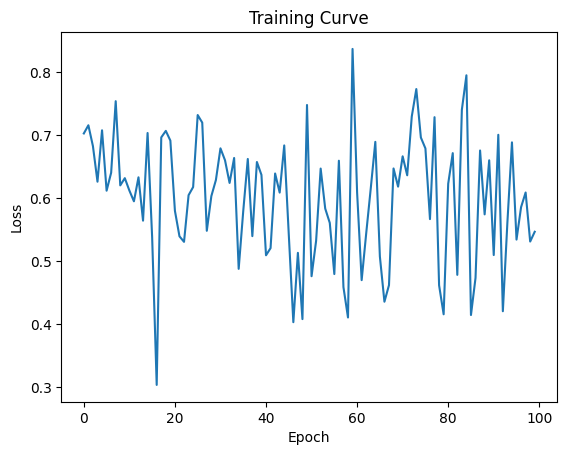

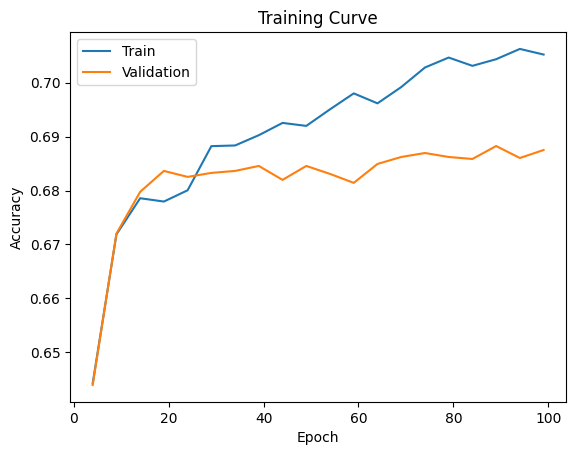

Final Test Accuracy: 0.6878687315634219


In [ ]:
mymodel = nn.Sequential(nn.Linear(50, 30), nn.ReLU(), nn.Linear(30, 10), nn.ReLU(), nn.Linear(10, 2))
train_network(mymodel, train_loader, valid_loader, num_epochs=100, learning_rate=1e-4)
print("Final Test Accuracy:", get_accuracy(mymodel, test_loader))


**Sentiment Analysis with Recurrent Model**
- Here in each sequence, we store the word's index that correspond to a GloVe word vector for memory efficiency sake, we use nn.Embedding layer to access word embedding such that we can look up words simultaneously

In [ ]:
def tweet_to_index(embedding):
    train, valid, test = [], [], []
    for i, line in enumerate(get_data(path)):
        if i % 29 == 0:
            tweet = line[-1]
            # Here we look up the index in embedding stoi that matches the word
            index = [embedding.stoi[w] for w in split_tweet(tweet) if w in embedding.stoi]
            if not index: continue # if the tweet has no embedding, we ignore
            index = torch.tensor(index) # convert index to pytorch tensor
            label = torch.tensor(int(line[0]=="4")).long()
            if i % 5 < 3:
                train.append((index, label))
            elif i % 5 == 4:
                valid.append((index, label))
            else:
                test.append((index, label))
    return train, valid, test

train, valid, test = tweet_to_index(glove)

In [ ]:
glove_emb = nn.Embedding.from_pretrained(glove.vectors)

for tweet, label in train:
    print(tweet.shape)
    print(glove_emb(tweet).shape)
    break

torch.Size([21])
torch.Size([21, 50])


Because each sequences has nonuniform length, we cannot use torch Dataloader. To address this problem, we can use the function following function: `torch.nn.utils.rnn.pad_sequence`

In [ ]:
from torch.nn.utils.rnn import pad_sequence
import random

class TweetBatcher:
    def __init__(self, tweets, batch_size=32, drop_last=False):
        # Store tweets in dictionary with length as key and list of
        # tweets of that length as value
        self.tweets_by_length = {}
        for words, label in tweets:
            length = words.shape[0]
            if length not in self.tweets_by_length:
                self.tweets_by_length[length] = []
            self.tweets_by_length[length].append((words, label),)
        # Iterate through tweet_by_length and write load the tweets of
        # the same length into dataloader object
        self.loaders = {wlen : torch.utils.data.DataLoader(tweets,
                                                          batch_size=batch_size,
                                                          shuffle=True,
                                                          drop_last=drop_last) for wlen, tweets in self.tweets_by_length.items()}

    def __iter__(self): # called by python when using object as an iterator
        iters = [iter(loader) for loader in self.loaders.values()]
        while iters:
            im = random.choice(iters)
            try:
                yield next(im)
            except StopIteration:
                iters.remove(im)

In [ ]:
for i, (tweets, labels) in enumerate(TweetBatcher(train, drop_last=True)):
    if i > 10: break
    print(tweets.shape, labels.shape)

torch.Size([32, 16]) torch.Size([32])
torch.Size([32, 34]) torch.Size([32])
torch.Size([32, 29]) torch.Size([32])
torch.Size([32, 18]) torch.Size([32])
torch.Size([32, 11]) torch.Size([32])
torch.Size([32, 12]) torch.Size([32])
torch.Size([32, 6]) torch.Size([32])
torch.Size([32, 20]) torch.Size([32])
torch.Size([32, 31]) torch.Size([32])
torch.Size([32, 24]) torch.Size([32])
torch.Size([32, 19]) torch.Size([32])


In [ ]:
def train_rnn_network(model, train, valid, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []
    for epoch in range(num_epochs):
        for tweets, labels in train:
            optimizer.zero_grad()
            pred = model(tweets)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_loader))
        valid_acc.append(get_accuracy(model, valid_loader))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, train_acc[-1], valid_acc[-1]))
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

def get_accuracy(model, data_loader):
    correct, total = 0, 0
    for tweets, labels, in data_loader:
        output = model(tweets)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

class TweetLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TweetLSTM, self).__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Look up the embedding
        x = self.emb(x)
        # Set an initial hidden state and cell state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        c0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the LSTM
        out, _ = self.rnn(x, (h0, c0))
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
train_loader = TweetBatcher(train, batch_size=64, drop_last=True)
valid_loader = TweetBatcher(valid, batch_size=64, drop_last=False)
test_loader = TweetBatcher(test, batch_size=64, drop_last=False)

Epoch 1; Loss 0.678522; Train Acc 0.504883; Val Acc 0.502774
Epoch 2; Loss 0.681802; Train Acc 0.532510; Val Acc 0.531429
Epoch 3; Loss 0.687010; Train Acc 0.596869; Val Acc 0.598836
Epoch 4; Loss 0.676125; Train Acc 0.605973; Val Acc 0.608751
Epoch 5; Loss 0.685455; Train Acc 0.609501; Val Acc 0.608751
Epoch 6; Loss 0.680883; Train Acc 0.616778; Val Acc 0.614482
Epoch 7; Loss 0.666872; Train Acc 0.628371; Val Acc 0.628491
Epoch 8; Loss 0.639155; Train Acc 0.639176; Val Acc 0.639043
Epoch 9; Loss 0.621042; Train Acc 0.650863; Val Acc 0.650596
Epoch 10; Loss 0.632734; Train Acc 0.655273; Val Acc 0.658419
Epoch 11; Loss 0.633006; Train Acc 0.658014; Val Acc 0.663968
Epoch 12; Loss 0.611632; Train Acc 0.661574; Val Acc 0.666515
Epoch 13; Loss 0.635969; Train Acc 0.663716; Val Acc 0.669153
Epoch 14; Loss 0.641999; Train Acc 0.664661; Val Acc 0.672701
Epoch 15; Loss 0.605740; Train Acc 0.667465; Val Acc 0.672064
Epoch 16; Loss 0.576935; Train Acc 0.669922; Val Acc 0.673883
Epoch 17; Loss 0.

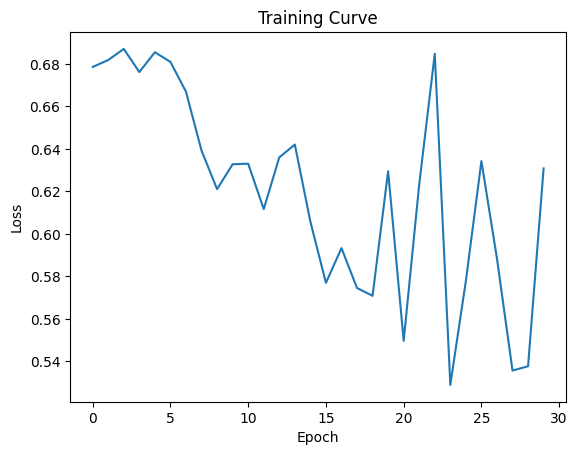

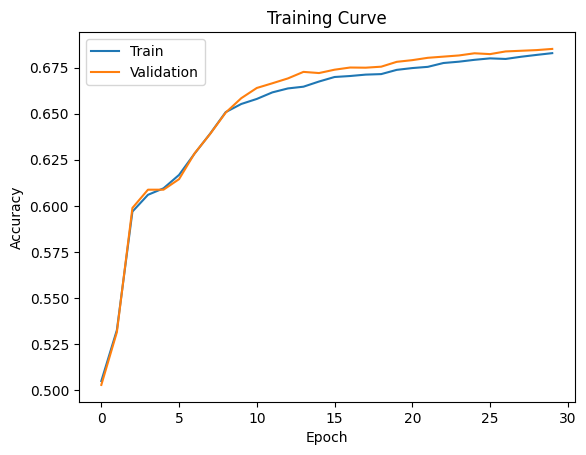

0.6761203526952095

In [ ]:
model = TweetLSTM(50, 50, 2)
train_rnn_network(model, train_loader, valid_loader, num_epochs=30, learning_rate=1e-5)
get_accuracy(model, test_loader)